In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


# * Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, ShuffleSplit
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, max_error
from sklearn.neural_network import MLPRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Problem Discussion

In [3]:
Sample_data=pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv')
Sample_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1000 non-null   int64  
 1   total_amount  1000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 15.8 KB


**1.1 Problem Statement:**- 

Business Objective: - Develop predictive models to estimate the total amount paid by travelers for taxi rides.

Outout:- total_amount (total amount paid by travelers)

the output (total_amount) is a float value so the given problem is a **Single Supervised Regression** Problem.



**1.2 Performance Evaluation**

The performance of the Regressoin Model will be evaluated on the basis of R2 score.

# 2. Data Exploration



**2.1 Loading the Training Dataset**

In the traing dataset, there are 175000 samples with 17 colunmns.

16 are feactures variables and 1 is label variable that is total_amount

In [4]:
Train_data=pd.read_csv("/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv")
print(f'Shape of training dataset : {Train_data.shape}')
print(f'List of columns name:{Train_data.columns}')

Shape of training dataset : (175000, 17)
List of columns name:Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee'],
      dtype='object')


In [5]:
Train_data.sample(6)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
43871,1,2023-06-28 17:24:19,2023-06-28 17:58:52,1.0,0.65,1.0,N,208,157,Cash,2.5,4.572667,0.0,1.0,13.00,2.5,0.00
146045,0,2023-06-29 10:09:07,2023-06-29 12:26:45,2.0,1.60,1.0,N,99,30,Credit Card,2.5,3.427643,0.0,1.0,31.90,2.5,0.00
137146,1,2023-06-30 18:46:37,2023-06-30 20:06:09,1.0,1.90,1.0,N,124,233,Credit Card,2.5,7.619989,0.0,1.0,19.32,0.0,0.00
128674,1,2023-06-29 18:31:56,2023-06-29 20:00:39,1.0,1.31,1.0,N,230,63,unknown,2.5,3.859965,0.0,1.0,15.10,2.5,0.00
71925,1,2023-06-30 18:03:43,2023-06-30 19:04:14,1.0,11.89,1.0,N,122,249,Cash,7.5,1.048984,0.0,1.0,57.85,0.0,1.75
67015,1,2023-06-30 11:57:15,2023-06-30 12:27:36,3.0,1.68,1.0,N,34,74,Credit Card,0.0,7.325223,0.0,1.0,19.32,2.5,0.00


**2.2 Feactures**

No. of Numerical variavle = 12

No. of Categorical variables=4

Descriptation of feactures:-

1. total_amount: The total amount paid by the traveler for the taxi ride.
1. VendorID: An identifier for taxi vendors.
1. tpep_pickup_datetime and tpep_dropoff_datetime: Timestamps indicating pickup and dropoff times.
1. passenger_count: The number of passengers during the ride.
1. trip_distance: The distance traveled during the trip.
1. RatecodeID: Rate code for the ride.
1. store_and_fwd_flag: A flag indicating whether the trip data was stored and forwarded.
1. PULocationID and DOLocationID: Pickup and dropoff location identifiers.
1. payment_type: Payment type used for the ride.

In [6]:
cat_columns=Train_data.select_dtypes(exclude = 'number').columns.to_list()
num_columns=Train_data.select_dtypes(include = 'number').columns.to_list()
print(f'List of Numerical columns : {num_columns}')
print(f'List of categorical columns : {cat_columns}')

List of Numerical columns : ['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']
List of categorical columns : ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag', 'payment_type']


**2.3 Data Statistics**



In [7]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

In [8]:
Train_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,175000.000000,168923.000000,175000.000000,168923.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,168923.000000,168923.000000
mean,0.728377,1.357678,5.145930,1.518307,132.710349,132.701429,1.932143,6.127497,0.646816,0.979689,29.633901,2.246971,0.158825
std,0.445606,0.891283,394.971052,6.514678,76.148799,76.192493,1.948497,4.610834,2.328274,0.198775,25.425206,0.819216,0.511968
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-7.500000,0.000079,-29.300000,-1.000000,-576.750000,-2.500000,-1.750000
25%,0.000000,1.000000,1.080000,1.000000,67.000000,67.000000,0.000000,3.473321,0.000000,1.000000,16.300000,2.500000,0.000000
50%,1.000000,1.000000,1.840000,1.000000,133.000000,133.000000,1.000000,5.286217,0.000000,1.000000,21.450000,2.500000,0.000000
75%,1.000000,1.000000,3.610000,1.000000,199.000000,199.000000,2.500000,7.502746,0.000000,1.000000,31.800000,2.500000,0.000000
max,2.000000,9.000000,135182.060000,99.000000,264.000000,264.000000,11.750000,484.876151,80.000000,1.000000,587.250000,2.500000,1.750000


array([[<Axes: title={'center': 'VendorID'}>,
        <Axes: title={'center': 'passenger_count'}>,
        <Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>],
       [<Axes: title={'center': 'PULocationID'}>,
        <Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'extra'}>,
        <Axes: title={'center': 'tip_amount'}>],
       [<Axes: title={'center': 'tolls_amount'}>,
        <Axes: title={'center': 'improvement_surcharge'}>,
        <Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'congestion_surcharge'}>],
       [<Axes: title={'center': 'Airport_fee'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

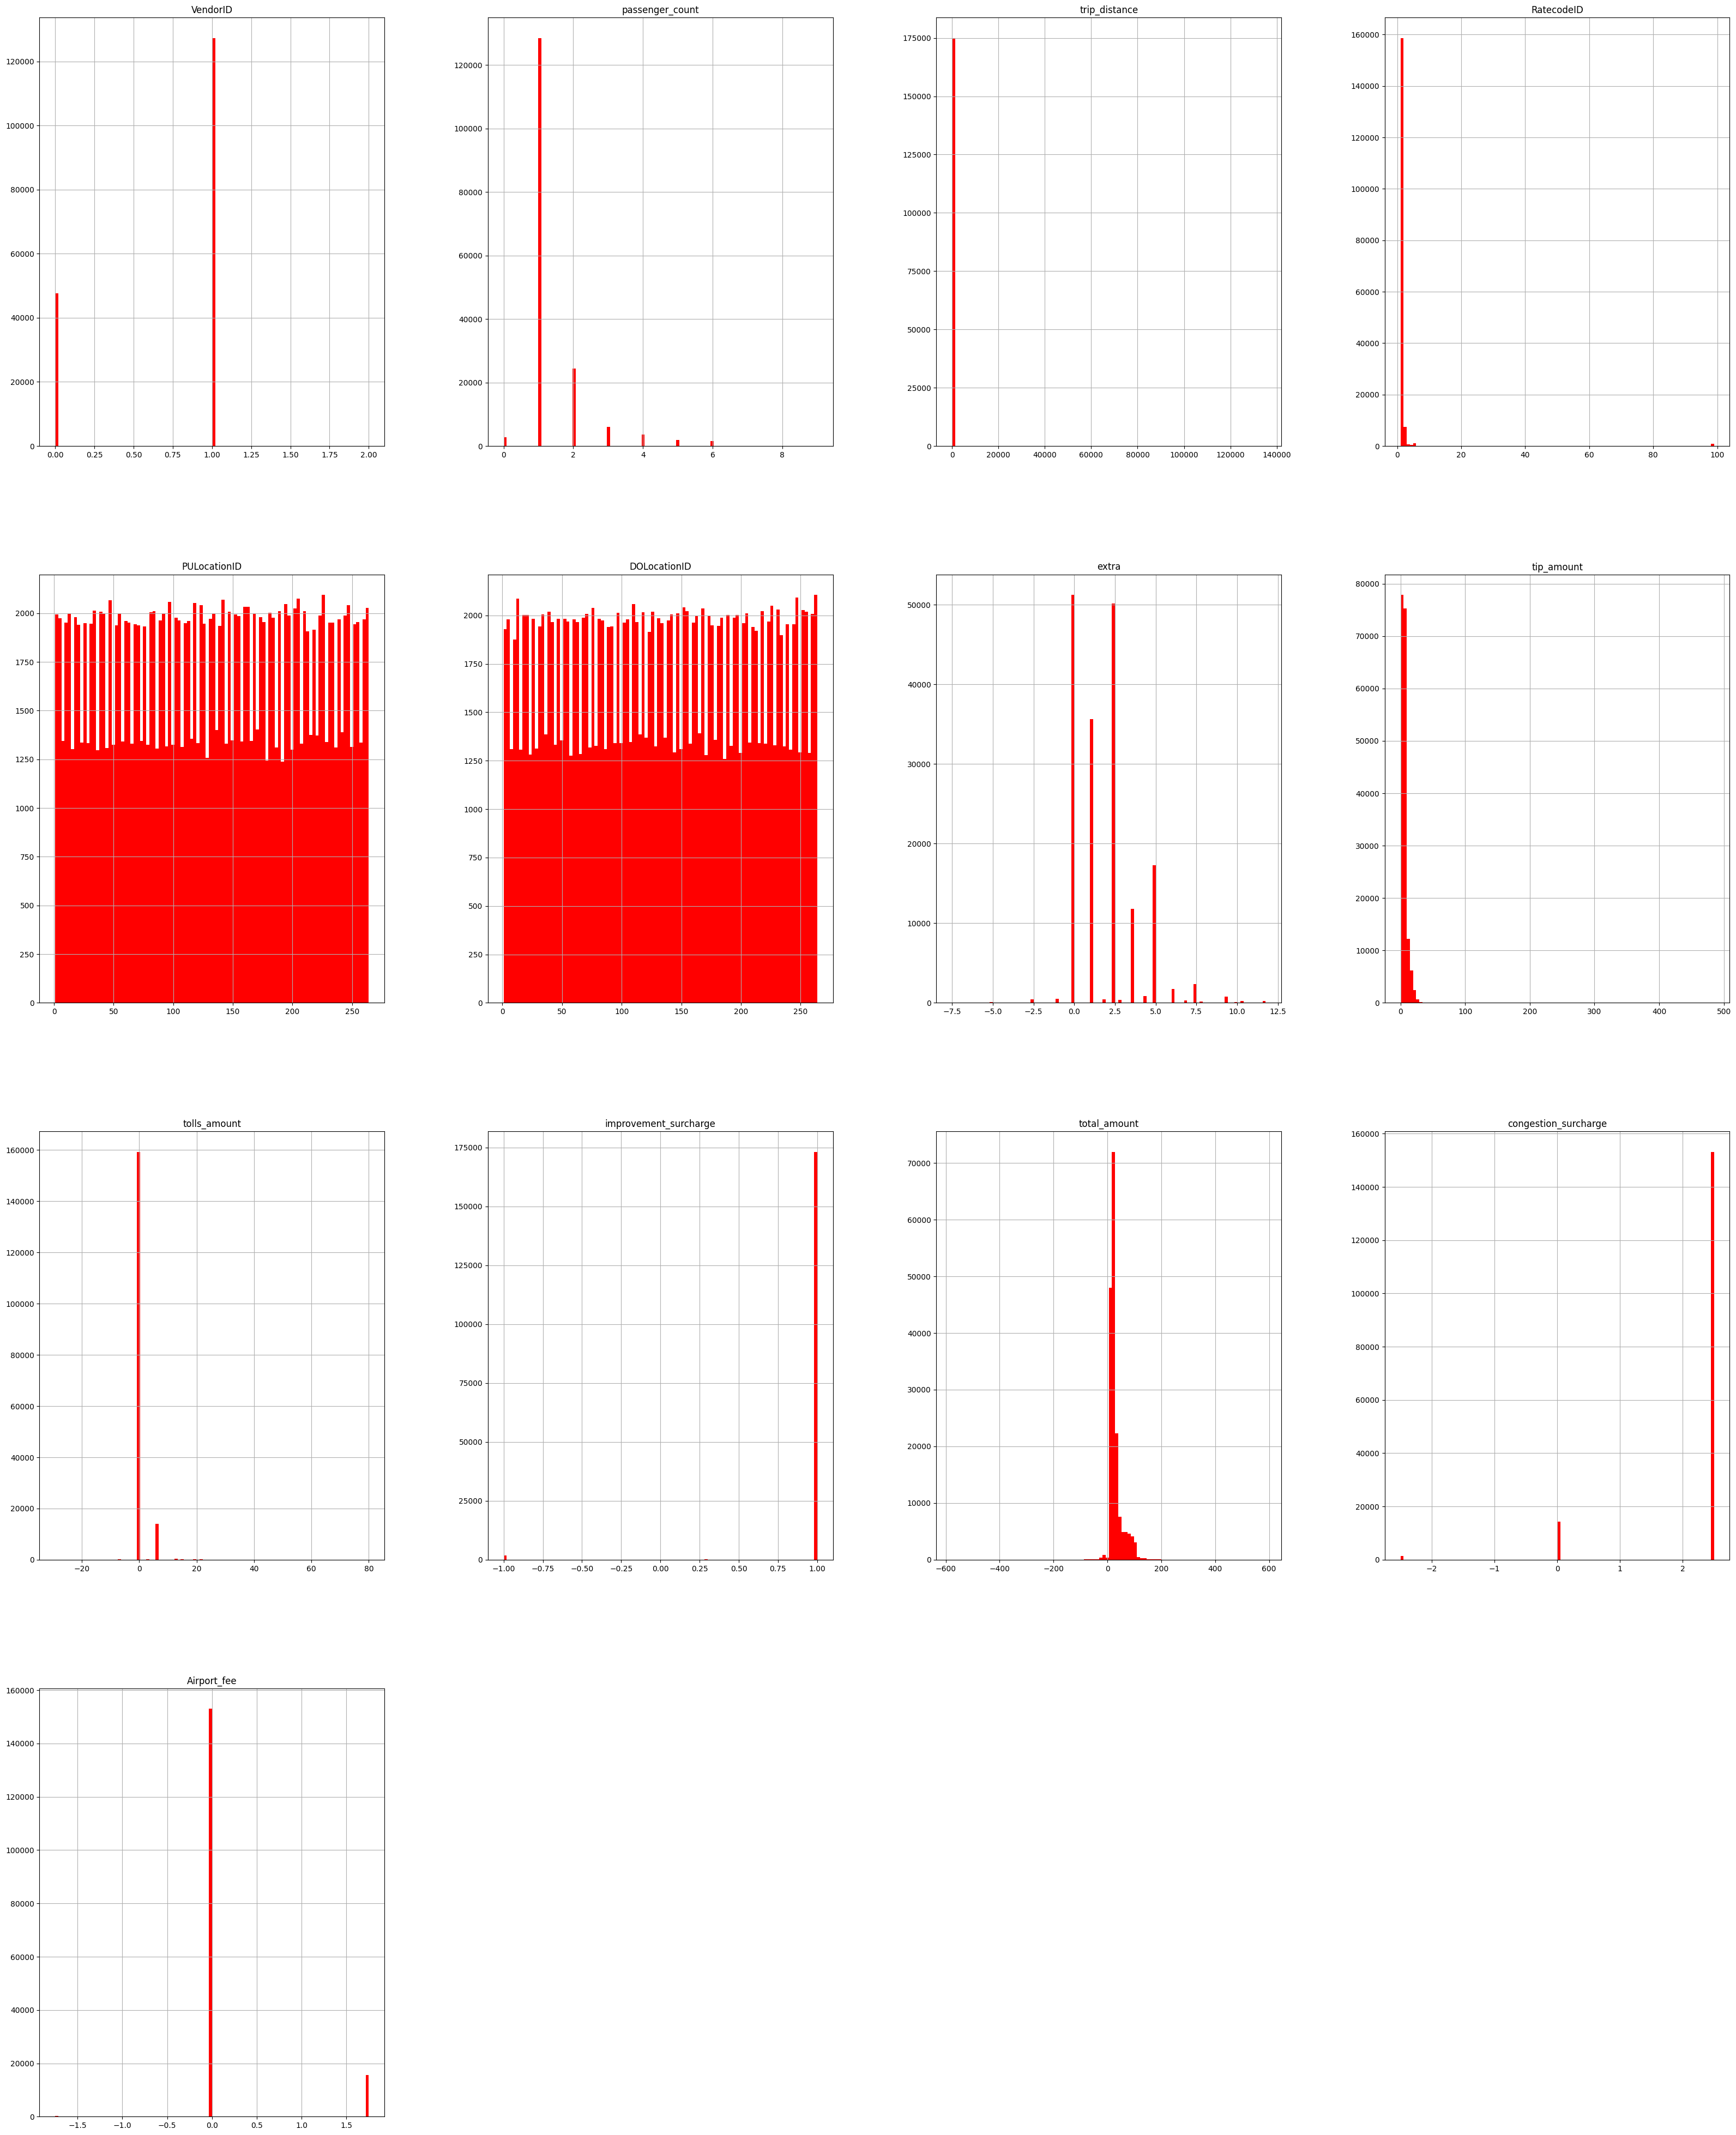

In [9]:
#Plotting the histogram of each feacture to oberve the it's distributation
Train_data.hist(bins=100,color = 'red', figsize=([40,50]))

Text(0.5, 1.0, 'payment_type')

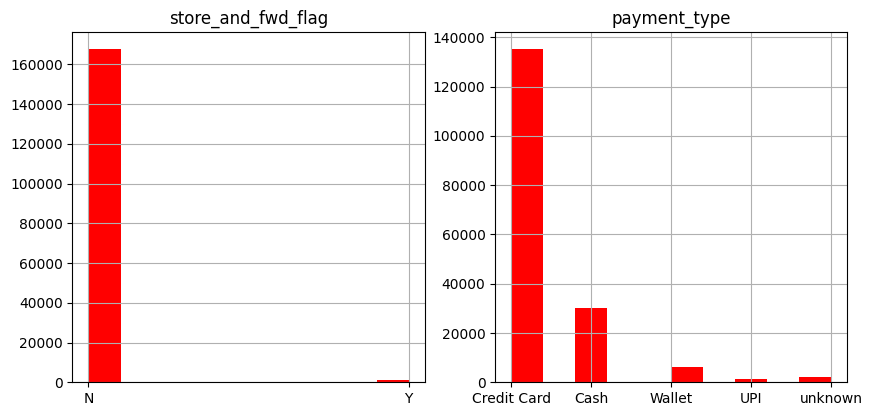

In [10]:
plt.subplot(2,2,1)
Train_data.store_and_fwd_flag.hist(bins=10,color = 'red', figsize=([10,10]))
plt.title('store_and_fwd_flag')
plt.subplot(2,2,2)
Train_data.payment_type.hist(bins=10,color = 'red', figsize=([10,10]))
plt.title('payment_type')

# 3. Data Visualization 

**3.1 Null values in dataset**

In [11]:
#To check the null values in all columns
Train_data.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

**3.2 Correlation**

In [12]:
#Correlation amoung Numerical features and total_amount
corrmatrix=Train_data[num_columns].corr()
corrmatrix['total_amount']

VendorID                 0.039695
passenger_count          0.053224
trip_distance            0.009911
RatecodeID               0.055527
PULocationID             0.000715
DOLocationID            -0.002954
extra                    0.234346
tip_amount               0.638658
tolls_amount             0.684765
improvement_surcharge    0.224036
total_amount             1.000000
congestion_surcharge    -0.147765
Airport_fee              0.597829
Name: total_amount, dtype: float64

<Axes: >

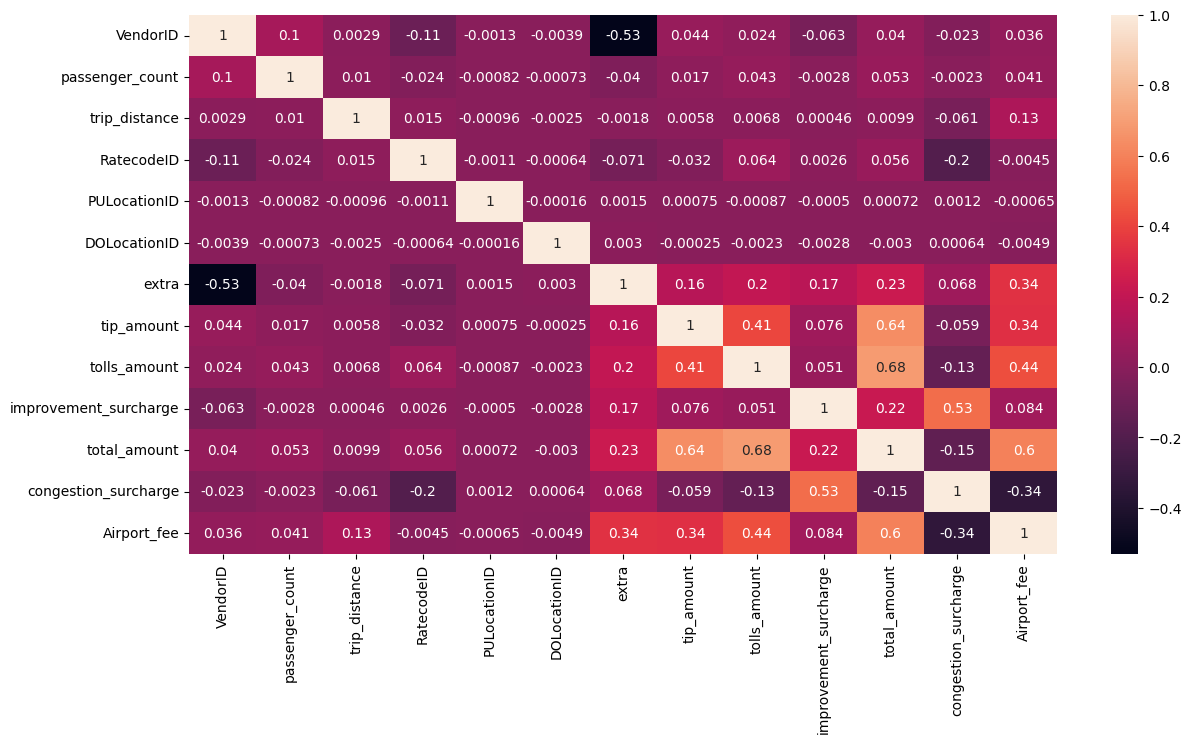

In [13]:
# Heatmap to show the correlation amoung  numerical variables
plt.figure(figsize=(14,7))
sbn.heatmap(corrmatrix,annot = True,)

**3.3 Outliers Detection with boxplot**

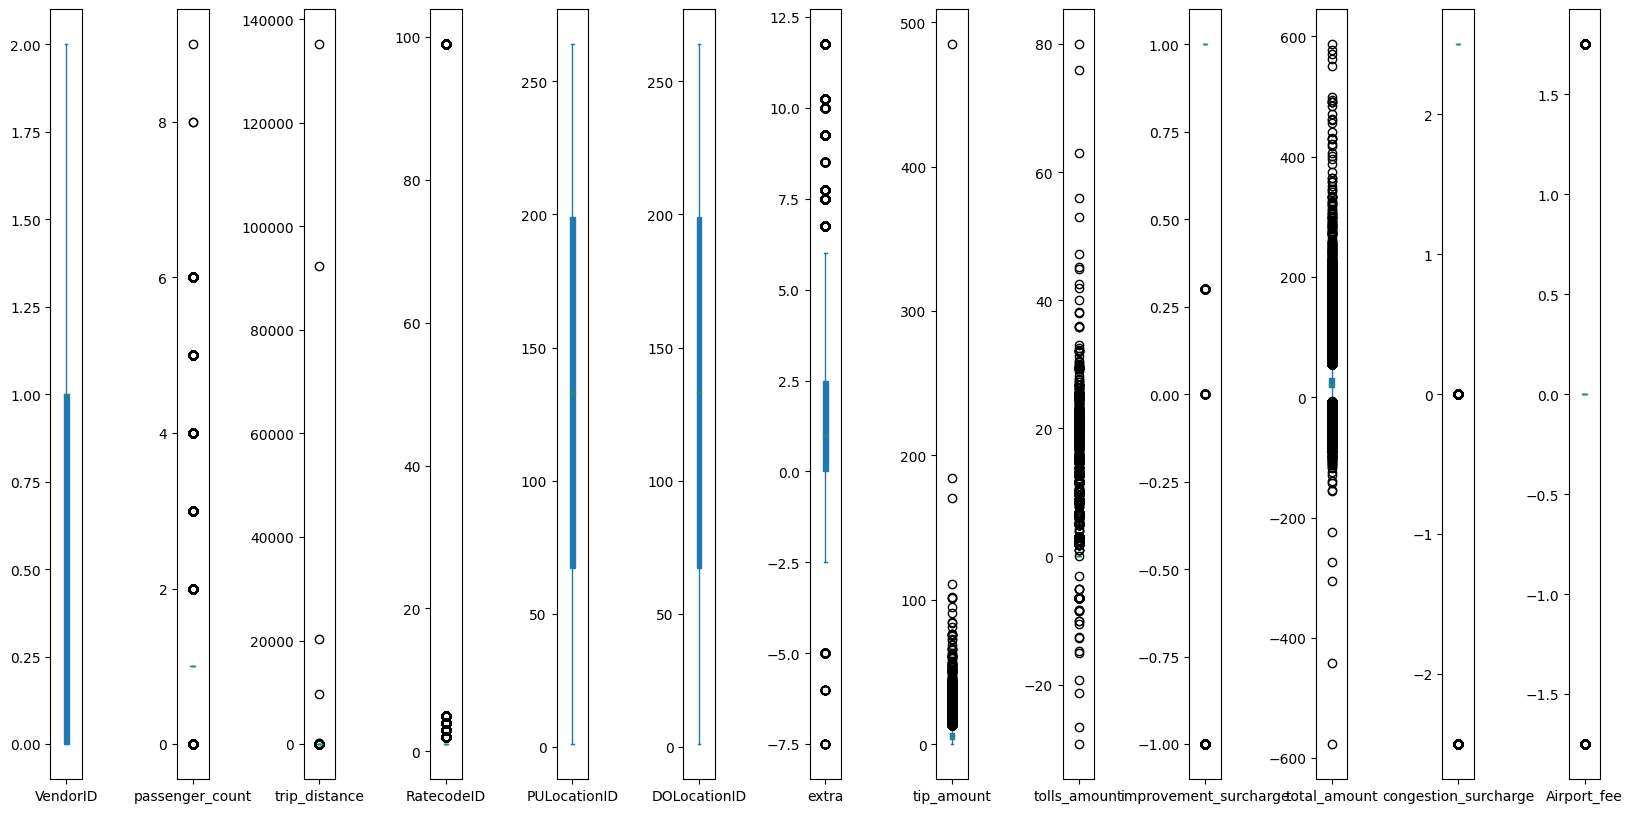

In [14]:
#plotting the boxplot to observe the outliers
Train_data.plot(kind='box',sharey = False, subplots=True, figsize=(20,10),patch_artist=True,return_type='both')
plt.subplots_adjust(wspace = 3)
plt.show()

**3.4 Split Training data into training and validation**

In [15]:
train_data, val_data=train_test_split(Train_data, test_size=0.2,random_state=42)
print(f'Shape of training data: {train_data.shape}')
print(f'Shape of validation data: {val_data.shape}')

Shape of training data: (140000, 17)
Shape of validation data: (35000, 17)


# 4. Data preprocessing 
As we observed the target variable ("Total_amount") is real number and contineous. That's why, this is a Regression problem.

**Feature extraction**
1. tpep_pickup_datetime
1. tpep_dropoff_datetime

These features are categorical variables and do not give directly any useful information. After converting thes into datetime and then extracting the information about the hour of day gives a useful feactures and their differece give us time duration which is a usefull feacture for model training

**Missing values** : list of columns
1. RatecodeID  : datatype-int
1. passenger_count : datatype-int
1. store_and_fwd_flag : datatype-categorical
1. congestion_surcharge : datatype-float
1. Airport_fee : datatype-float
so we have to fill null of numerical columns with mean value and null value of categorical columns(store_and_fwd_flag) with most frequent value

**Unknown values** : list of columns
1. payment_type : name of unknown element- "unknown"
we replace the unknown value with most frequent value that is credit_card

**Categorical data** : list of columns
1. store_and_fwd_flag  : 'N' have 90% and 'Y' have 10%
1. payment_type : Most frequest element-"credit_card"
To convert the categorical columns to numerical columns apply OneHotEncoding


**Feature scaling**
1. trip_distance 
1. extra 
1. tip_amount 
1. tolls_amount 
1. improvement_surcharge 
1. passenger_count
1. Duration 
1. congestion_surcharge
1. Airport_fee

These fectures have either normal distribuation or uknown with outliers and have different scaling. So StabdardScaling technics to scale the feacutre which is less affected by outliers 

**Less Impotant feactures**
1. PULocationID
1. DOLocationID

**4.1 Feacture engineering**

In [16]:
# for training data
train_data['tpep_dropoff_datetime'] = pd.to_datetime(train_data['tpep_dropoff_datetime'])  # converting from string to datetime formate.
train_data['tpep_pickup_datetime'] = pd.to_datetime(train_data['tpep_pickup_datetime']) # converting from string to datetime formate.
#creating new feacture (Duration) from 'tpep_pickup_datetime' and 'tpep_dropoff_datetime'.
train_data['Duration']=(abs(train_data['tpep_dropoff_datetime']-train_data['tpep_pickup_datetime']).dt.total_seconds())/60
# creating new column to know the day of week.
train_data['week']=train_data['tpep_pickup_datetime'].dt.dayofweek 
#converting the datetime formate into hour to know 
train_data['tpep_pickup_datetime']=train_data['tpep_pickup_datetime'].dt.hour
# seprate the feactures and label
X_train=train_data.drop(['total_amount','tpep_dropoff_datetime','PULocationID', 'DOLocationID'], axis=1)
y_train=train_data["total_amount"].copy()



# for validationdata
val_data['tpep_dropoff_datetime'] = pd.to_datetime(val_data['tpep_dropoff_datetime'])  # converting from string to datetime formate.
val_data['tpep_pickup_datetime'] = pd.to_datetime(val_data['tpep_pickup_datetime']) # converting from string to datetime formate.
#creating new feacture (Duration) from 'tpep_pickup_datetime' and 'tpep_dropoff_datetime'.
val_data['Duration']=(abs(val_data['tpep_dropoff_datetime']-val_data['tpep_pickup_datetime']).dt.total_seconds())/60
# creating new column to know the day of week.
val_data['week']=val_data['tpep_dropoff_datetime'].dt.dayofweek 
#converting the datetime formate into hour to know 
val_data['tpep_pickup_datetime']=val_data['tpep_pickup_datetime'].dt.hour
# seprate the feactures and label
X_val=val_data.drop(['total_amount','tpep_dropoff_datetime','PULocationID', 'DOLocationID'], axis=1)
y_val=val_data["total_amount"].copy()

print(f'For traing, shape of feactures data is : {X_train.shape} and of label data is :{y_train.shape}')
print(f'For validation, shape of feactures data is : {X_val.shape} and of label data is :{y_val.shape}')

For traing, shape of feactures data is : (140000, 15) and of label data is :(140000,)
For validation, shape of feactures data is : (35000, 15) and of label data is :(35000,)


**4.2 Imputing missing values for categorical columns**

In [17]:
# for traning data
X_train['store_and_fwd_flag'].fillna('N',inplace=True) # more the 90% samples have 'N' value for 'store_and_fwd_flag' variable.
X_train['payment_type'].replace('unknown', 'Credit Card', inplace = True) # Most frequent value in 'payment_type' column is 'Credit Card'.

# for validation data
X_val['store_and_fwd_flag'].fillna('N',inplace=True)
X_val['payment_type'].replace('unknown', 'Credit Card', inplace = True)

**4.3 ColumnTransformer to combine SimpleImputer and OneHotEncoding**

In [18]:
cat_columns=X_train.select_dtypes(exclude = 'number').columns.to_list()
num_columns=X_train.select_dtypes(include = 'number').columns.to_list()
print(f'List of Numerical columns : {num_columns}')
print(f'List of categorical columns : {cat_columns}')

List of Numerical columns : ['VendorID', 'tpep_pickup_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee', 'Duration', 'week']
List of categorical columns : ['store_and_fwd_flag', 'payment_type']


In [19]:
ct = ColumnTransformer(
       [('imputenum', SimpleImputer(strategy='mean'),num_columns ),# column transform to impute the numerical variable with mean value 
        ("onehot", OneHotEncoder(handle_unknown='ignore' ), cat_columns),  # column transform to conver categorical variable to numerical value
      ],remainder='passthrough')
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('imputenum', SimpleImputer(),
                                 ['VendorID', 'tpep_pickup_datetime',
                                  'passenger_count', 'trip_distance',
                                  'RatecodeID', 'extra', 'tip_amount',
                                  'tolls_amount', 'improvement_surcharge',
                                  'congestion_surcharge', 'Airport_fee',
                                  'Duration', 'week']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['store_and_fwd_flag', 'payment_type'])])

In [20]:
# fit and transform traing data 
tran_train=ct.fit_transform(X_train)
X_train_t=pd.DataFrame(tran_train)
print(f'Shape of transformed traing feactures data: {X_train_t.shape}')

#fit and transform validation data 
tran_val=ct.transform(X_val)
X_val_t=pd.DataFrame(tran_val)
print(f'Shape of transformed validation feactures data: {X_val_t.shape}')

Shape of transformed traing feactures data: (140000, 19)
Shape of transformed validation feactures data: (35000, 19)


# 5. Models:-
# Model-1 : ExtraTreesRegressor

**1.1 Model Training**

In [21]:
extra_reg= ExtraTreesRegressor(max_depth=20, n_estimators=200,bootstrap=True, random_state=42)
extra_reg.fit(X_train_t,y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=20, n_estimators=200,
                    random_state=42)

**1.2 Scores and Errors**

In [22]:
y_train_pre=extra_reg.predict(X_train_t)
y_val_pre=extra_reg.predict(X_val_t)
train_score=r2_score(y_train, y_train_pre)
val_score=r2_score(y_val,y_val_pre)
rmse_train=mean_squared_error(y_train, y_train_pre, squared=False)
rmse_val=mean_squared_error(y_val,y_val_pre,  squared=False)
maxe_train=max_error(y_train, y_train_pre)
maxe_val=max_error(y_val, y_val_pre)
print(f'Training R2_Score : {train_score}')
print(f'Validation R2_Score : {val_score}')
print(f'Training RMS Erroe: {rmse_train}')
print(f'Validation RMS Erroe: {rmse_val}')
print(f'Training max Erroe: {maxe_train}')
print(f'Validation max Erroe: {maxe_val}')

Training R2_Score : 0.979669267137383
Validation R2_Score : 0.9575507874962369
Training RMS Erroe: 3.622221116934826
Validation RMS Erroe: 5.255870151059405
Training max Erroe: 272.57533489719674
Validation max Erroe: 316.99460000000016


**1.3 Cross validation**

In [23]:
cv=ShuffleSplit(n_splits=3, test_size=.2)
cv_results=cross_validate(extra_reg, X_train_t, y_train, scoring='r2', cv=cv, return_train_score=True)
cv_results

{'fit_time': array([29.34828067, 28.99728799, 30.84790444]),
 'score_time': array([0.91719317, 0.85570693, 0.89623618]),
 'test_score': array([0.91912941, 0.95765128, 0.92982671]),
 'train_score': array([0.98244269, 0.97966199, 0.98132573])}

**1.4 Performance of model**

Text(0.5, 1.0, 'Validation error')

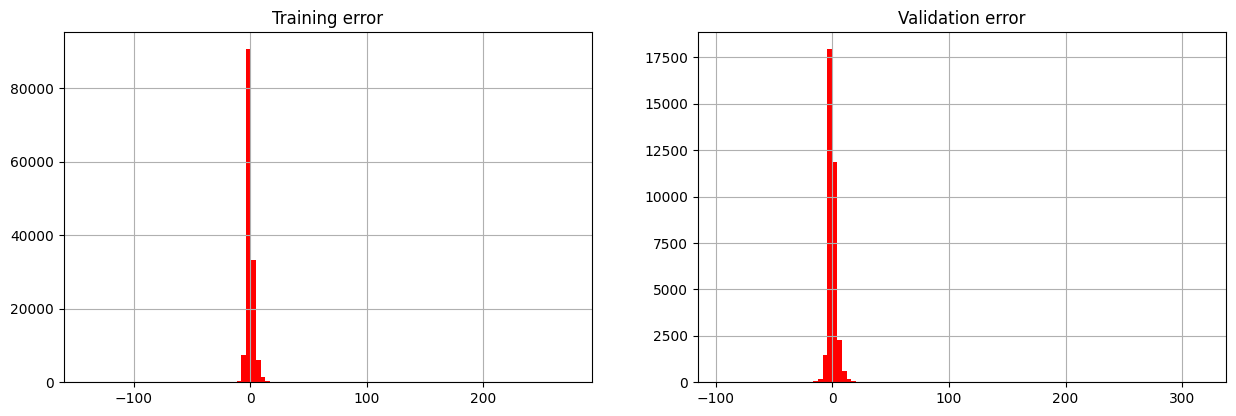

In [24]:
diff_train=y_train-y_train_pre
diff_val=y_val-y_val_pre
plt.subplot(2,2,1)
diff_train.hist(bins=100,color = 'red', figsize=([15,10]))
plt.title('Training error')
plt.subplot(2,2,2)
diff_val.hist(bins=100,color = 'red', figsize=([15,10]))
plt.title('Validation error')

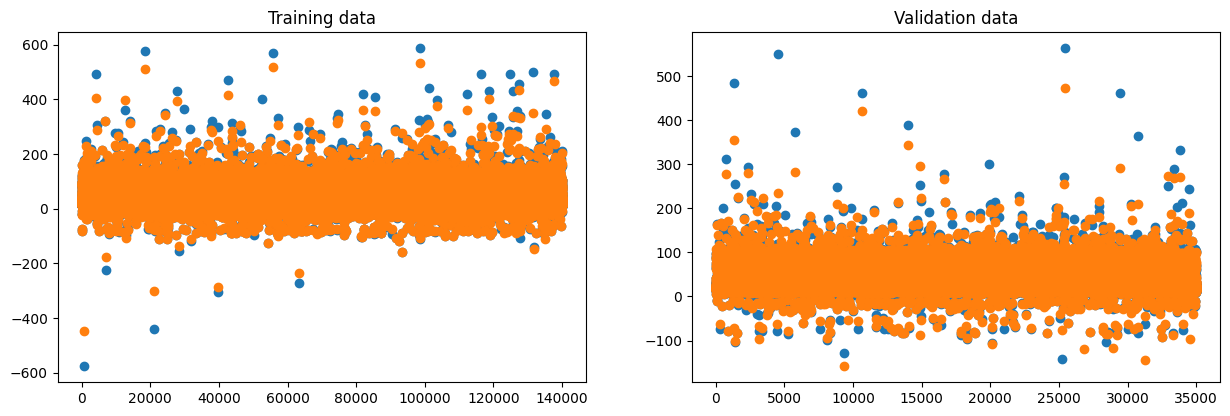

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(np.arange(len(y_train)),y_train)
plt.scatter(np.arange(len(y_train)), y_train_pre)
plt.title('Training data')
plt.subplot(2,2,2)
plt.scatter(np.arange(len(y_val)),y_val)
plt.scatter(np.arange(len(y_val)), y_val_pre)
plt.title('Validation data')
plt.show()

**1.5 Hyperparameter Tuning**

In [26]:
# param_grid = [{
#              'n_estimators':[50, 150, 200],
#              'max_depth':[15,20,30],
#              #'min_samples_leaf':[1,2,3],
#              #'min_samples_split':[2,3,4]
# }]
# grid_search = GridSearchCV(extra_reg, param_grid, cv=3,
#                            scoring='r2',return_train_score=True)
# grid_search.fit(X_train_t,y_train)
# print(grid_search.best_params_)
# train_score=grid_search.score(X_train_t, y_train)
# val_score=grid_search.score(X_val_t,y_test)
# print(f'Training Score : {train_score}')
# print(f'Validation Score : {val_score}')

**1.4 Preprocessing for Test data and submission of predicted values**

In [27]:
# Test_data=pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
# Test_data['tpep_dropoff_datetime'] = pd.to_datetime(Test_data['tpep_dropoff_datetime'])
# Test_data['tpep_pickup_datetime'] = pd.to_datetime(Test_data['tpep_pickup_datetime'])
# Test_data['Duration']=(abs(Test_data['tpep_pickup_datetime']-Test_data['tpep_dropoff_datetime']).dt.total_seconds())/60
# Test_data['week']=Test_data['tpep_dropoff_datetime'].dt.dayofweek
# Test_data['tpep_pickup_datetime']=Test_data['tpep_pickup_datetime'].dt.hour
# test_data=Test_data.drop(['tpep_dropoff_datetime','PULocationID', 'DOLocationID'], axis=1)
# # Impute missing values for categorical columns
# test_data['store_and_fwd_flag'].fillna('N',inplace=True)
# test_data['payment_type'].replace('unknown', 'Credit Card', inplace = True)
# # Transform of test data
# test_t=ct.transform(test_data)
# test_data_t=pd.DataFrame(test_t)
# print(f'Shape of Test data: {test_data_t.shape}')

# y_test_pred=pipe.predict(test_data_t)
# submission = pd.DataFrame(columns = ["ID","total_amount"])
# submission["ID"] = [i for i in range(1,len(y_test_pred)+1)] 
# submission["total_amount"] = pd.DataFrame(y_test_pred)
# submission.to_csv('submission.csv',index=False)

# Model- 2: RandomForestRegressor

In [28]:
randomforest=RandomForestRegressor(max_depth=15, n_estimators=200)
randomforest.fit(X_train_t,y_train)

RandomForestRegressor(max_depth=15, n_estimators=200)

In [29]:
y_train_pre=randomforest.predict(X_train_t)
y_val_pre=randomforest.predict(X_val_t)
train_score=r2_score(y_train, y_train_pre)
val_score=r2_score(y_val,y_val_pre)
rmse_train=mean_squared_error(y_train, y_train_pre, squared=False)
rmse_val=mean_squared_error(y_val,y_val_pre,  squared=False)
print(f'Training R2_Score : {train_score}')
print(f'Validation R2_Score : {val_score}')
print(f'Training RMS Erroe: {rmse_train}')
print(f'Validation RMS Erroe: {rmse_val}')

Training R2_Score : 0.9775840245130519
Validation R2_Score : 0.9612206255008057
Training RMS Erroe: 3.803446069794343
Validation RMS Erroe: 5.02354397314192


In [30]:
# cv=ShuffleSplit(n_splits=4, test_size=.2)
# cv_results=cross_validate(randomforest, X_train_t, y_train, scoring='r2', cv=cv, return_train_score=True)
# cv_results

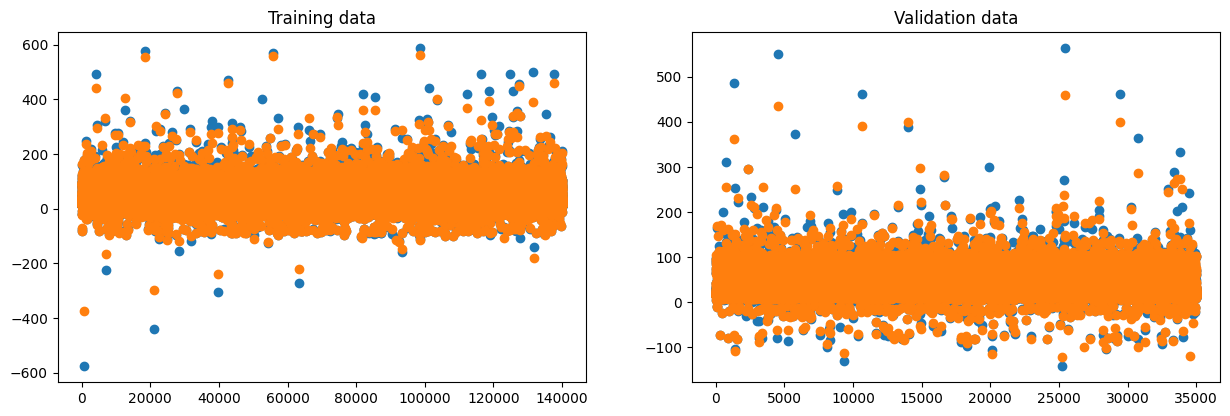

In [31]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(np.arange(len(y_train)),y_train)
plt.scatter(np.arange(len(y_train)), y_train_pre)
plt.title('Training data')
plt.subplot(2,2,2)
plt.scatter(np.arange(len(y_val)),y_val)
plt.scatter(np.arange(len(y_val)), y_val_pre)
plt.title('Validation data')
plt.show()

In [32]:
# param_grid = [{
#              'n_estimators':[50, 150, 200],
#              'max_depth':[15,20,30],
#              #'min_samples_leaf':[1,2,3],
#              #'min_samples_split':[2,3,4]
# }]
# grid_search = GridSearchCV(randomforest, param_grid, cv=3,
#                            scoring='r2',return_train_score=True)
# grid_search.fit(X_train_t,y_train)
# print(grid_search.best_params_)
# train_score=grid_search.score(X_train_t, y_train)
# val_score=grid_search.score(y_val_t,y_test)
# print(f'Training Score : {train_score}')
# print(f'Validation Score : {val_score}')

In [33]:
Test_data=pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
Test_data['tpep_dropoff_datetime'] = pd.to_datetime(Test_data['tpep_dropoff_datetime'])
Test_data['tpep_pickup_datetime'] = pd.to_datetime(Test_data['tpep_pickup_datetime'])
Test_data['Duration']=(abs(Test_data['tpep_pickup_datetime']-Test_data['tpep_dropoff_datetime']).dt.total_seconds())/60
Test_data['week']=Test_data['tpep_dropoff_datetime'].dt.dayofweek
Test_data['tpep_pickup_datetime']=Test_data['tpep_pickup_datetime'].dt.hour
test_data=Test_data.drop(['tpep_dropoff_datetime','PULocationID', 'DOLocationID'], axis=1)
# Impute missing values for categorical columns
test_data['store_and_fwd_flag'].fillna('N',inplace=True)
test_data['payment_type'].replace('unknown', 'Credit Card', inplace = True)
# Transform of test data
test_t=ct.transform(test_data)
test_data_t=pd.DataFrame(test_t)
print(f'Shape of Test data: {test_data_t.shape}')

y_test_pred=randomforest.predict(test_data_t)
submission = pd.DataFrame(columns = ["ID","total_amount"])
submission["ID"] = [i for i in range(1,len(y_test_pred)+1)] 
submission["total_amount"] = pd.DataFrame(y_test_pred)
submission.to_csv('submission.csv',index=False)

Shape of Test data: (50000, 19)


# Model- 3 : BaggingRegressor

In [34]:
baggingregressor=BaggingRegressor(n_estimators=100)
baggingregressor.fit(X_train_t,y_train)

BaggingRegressor(n_estimators=100)

In [35]:
y_train_pre=baggingregressor.predict(X_train_t)
y_val_pre=baggingregressor.predict(X_val_t)
train_score=r2_score(y_train, y_train_pre)
val_score=r2_score(y_val,y_val_pre)
rmse_train=mean_squared_error(y_train, y_train_pre, squared=False)
rmse_val=mean_squared_error(y_val,y_val_pre,  squared=False)
print(f'Training R2_Score : {train_score}')
print(f'Validation R2_Score : {val_score}')
print(f'Training RMS Erroe: {rmse_train}')
print(f'Validation RMS Erroe: {rmse_val}')

Training R2_Score : 0.9920737295003746
Validation R2_Score : 0.9611142016527374
Training RMS Erroe: 2.2616890002314007
Validation RMS Erroe: 5.03043241050835


In [36]:
cv=ShuffleSplit(n_splits=4, test_size=.2)
cv_results=cross_validate(baggingregressor, X_train_t, y_train, scoring='r2', cv=cv, return_train_score=True)
cv_results

{'fit_time': array([65.40464616, 66.23439455, 65.62201285, 65.91624951]),
 'score_time': array([1.39332962, 1.41021419, 1.4181242 , 1.41679406]),
 'test_score': array([0.94013522, 0.93822255, 0.94939272, 0.95611469]),
 'train_score': array([0.99106742, 0.99013191, 0.99109344, 0.99067116])}

In [37]:
# param_grid = [{
#              'n_estimators':[10, 50, 100],
#              'bootstrap':[True,False],
#              'bootstrap_features':[True,False],           
# }]
# grid_search = GridSearchCV(baggingregressor, param_grid, cv=3,
#                            scoring='r2',return_train_score=True)
# grid_search.fit(X_train_t,y_train)
# print(grid_search.best_params_)
# train_score=grid_search.score(X_train_t, y_train)
# val_score=grid_search.score(X_val_t,y_val)
# print(f'Training Score : {train_score}')
# print(f'Validation Score : {val_score}')

# Model- 4 : Decision Tree

In [38]:
decisiontree=DecisionTreeRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=4)        
decisiontree.fit(X_train_t,y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=4)

In [39]:
y_train_pre=decisiontree.predict(X_train_t)
y_val_pre=decisiontree.predict(X_val_t)
train_score=r2_score(y_train, y_train_pre)
val_score=r2_score(y_val,y_val_pre)
rmse_train=mean_squared_error(y_train, y_train_pre, squared=False)
rmse_val=mean_squared_error(y_val,y_val_pre,  squared=False)
print(f'Training R2_Score : {train_score}')
print(f'Validation R2_Score : {val_score}')
print(f'Training RMS Erroe: {rmse_train}')
print(f'Validation RMS Erroe: {rmse_val}')

Training R2_Score : 0.968427608302878
Validation R2_Score : 0.9406286062656398
Training RMS Erroe: 4.513902584231324
Validation RMS Erroe: 6.215820011477034


In [40]:
cv=ShuffleSplit(n_splits=4, test_size=.2)
cv_results=cross_validate(decisiontree, X_train_t, y_train, scoring='r2', cv=cv, return_train_score=True)
cv_results

{'fit_time': array([0.65108752, 0.64537859, 0.64476371, 0.64365101]),
 'score_time': array([0.0069015 , 0.00682235, 0.00675035, 0.00705409]),
 'test_score': array([0.91727119, 0.84017839, 0.93582398, 0.91685253]),
 'train_score': array([0.9666026 , 0.96985383, 0.96882562, 0.96419516])}

In [41]:
param_grid = [{
             'max_depth':[15,20,30],
             'min_samples_leaf':[1,2,3],
             'min_samples_split':[2,3,4]
}]
grid_search = GridSearchCV(decisiontree, param_grid, cv=3,
                           scoring='r2',return_train_score=True)
grid_search.fit(X_train_t,y_train)
print(grid_search.best_params_)
train_score=grid_search.score(X_train_t, y_train)
val_score=grid_search.score(X_val_t,y_val)
print(f'Training Score : {train_score}')
print(f'Validation Score : {val_score}')

{'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 3}
Training Score : 0.9684276673274835
Validation Score : 0.9405344031676445


# Model- 5 : KNN

In [42]:
pipe=Pipeline([("stabdard", StandardScaler() ),
               ('knn', KNeighborsRegressor())
               ])
pipe.fit(X_train_t,y_train)

Pipeline(steps=[('stabdard', StandardScaler()), ('knn', KNeighborsRegressor())])

In [43]:
y_train_pre=pipe.predict(X_train_t)
y_val_pre=pipe.predict(X_val_t)
train_score=r2_score(y_train, y_train_pre)
val_score=r2_score(y_val,y_val_pre)
rmse_train=mean_squared_error(y_train, y_train_pre, squared=False)
rmse_val=mean_squared_error(y_val,y_val_pre,  squared=False)
print(f'Training R2_Score : {train_score}')
print(f'Validation R2_Score : {val_score}')
print(f'Training RMS Erroe: {rmse_train}')
print(f'Validation RMS Erroe: {rmse_val}')

Training R2_Score : 0.8511507192765202
Validation R2_Score : 0.7746690461412434
Training RMS Erroe: 9.801032094013657
Validation RMS Erroe: 12.109333380486781


In [44]:
# cv=ShuffleSplit(n_splits=4, test_size=.2)
# cv_results=cross_validate(pipe, X_train_t, y_train, scoring='r2', cv=cv, return_train_score=True)
# cv_results

In [45]:
# param_grid = [{
#           'knn__n_neighbors':[4,5,6],
#               }]
# grid_search = GridSearchCV(pipe, param_grid, cv=3,
#                            scoring='r2',return_train_score=True)
# grid_search.fit(X_train_t,y_train)
# print(grid_search.best_params_)
# train_score=grid_search.score(X_train_t, y_train)
# val_score=grid_search.score(X_val_t,y_val)
# print(f'Training Score : {train_score}')
# print(f'Validation Score : {val_score}')

# Model - 6 : Polynomial Regression

In [46]:
pipe=Pipeline([("stabdard", StandardScaler() ),
               ('poly', PolynomialFeatures(degree=2)),
               ('lin_reg', LinearRegression())
               ])
pipe.fit(X_train_t,y_train)

Pipeline(steps=[('stabdard', StandardScaler()), ('poly', PolynomialFeatures()),
                ('lin_reg', LinearRegression())])

In [47]:
y_train_pre=pipe.predict(X_train_t)
y_val_pre=pipe.predict(X_val_t)
train_score=r2_score(y_train, y_train_pre)
val_score=r2_score(y_val,y_val_pre)
rmse_train=mean_squared_error(y_train, y_train_pre, squared=False)
rmse_val=mean_squared_error(y_val,y_val_pre,  squared=False)
print(f'Training R2_Score : {train_score}')
print(f'Validation R2_Score : {val_score}')
print(f'Training RMS Erroe: {rmse_train}')
print(f'Validation RMS Erroe: {rmse_val}')

Training R2_Score : 0.8845742431885988
Validation R2_Score : 0.88839595319245
Training RMS Erroe: 8.630775230546586
Validation RMS Erroe: 8.522161882778217


In [48]:
# param_grid = [{
#           'poly__interaction_only':[True,False],
#           'poly__include_bias':[True, False],
#           'poly__degree':[2,3]
#               }]
# grid_search = GridSearchCV(pipe, param_grid, cv=3,
#                            scoring='r2',return_train_score=True)
# grid_search.fit(X_train_t,y_train)
# print(grid_search.best_params_)
# train_score=grid_search.score(X_train_t, y_train)
# val_score=grid_search.score(X_val_t,y_val)
# print(f'Training Score : {train_score}')
# print(f'Validation Score : {val_score}')

# Model - 7 : MLPRegressor

In [49]:
pipe=Pipeline([("stabdard", StandardScaler() ),
               ('poly', PolynomialFeatures(degree=2)),
               ('mlp', MLPRegressor(hidden_layer_sizes=10))
               ])
pipe.fit(X_train_t,y_train)
#mlp=MLPRegressor(hidden_layer_sizes=10)
#mlp.fit(X_train_t, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('stabdard', StandardScaler()), ('poly', PolynomialFeatures()),
                ('mlp', MLPRegressor(hidden_layer_sizes=10))])

In [50]:
y_train_pre=pipe.predict(X_train_t)
y_val_pre=pipe.predict(X_val_t)
train_score=r2_score(y_train, y_train_pre)
val_score=r2_score(y_val,y_val_pre)
rmse_train=mean_squared_error(y_train, y_train_pre, squared=False)
rmse_val=mean_squared_error(y_val,y_val_pre,  squared=False)
print(f'Training R2_Score : {train_score}')
print(f'Validation R2_Score : {val_score}')
print(f'Training RMS Erroe: {rmse_train}')
print(f'Validation RMS Erroe: {rmse_val}')

Training R2_Score : 0.8901934837808902
Validation R2_Score : 0.9019684467051527
Training RMS Erroe: 8.418069319750577
Validation RMS Erroe: 7.987166729953223
